In [1]:
# This is the coursework 2 for the Reinforcement Leaning course 2021 taught at Imperial College London (https://www.imperial.ac.uk/computing/current-students/courses/70028/)
# The code is based on the OpenAI Gym original (https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html) and modified by Filippo Valdettaro and Prof. Aldo Faisal for the purposes of the course.
# There may be differences to the reference implementation in OpenAI gym and other solutions floating on the internet, but this is the defeinitive implementation for the course.

# Instaling in Google Colab the libraries used for the coursework
# You do NOT need to understand it to work on this coursework

# WARNING: if you don't use this Notebook in Google Colab, this block might print some warnings (do not mind them)

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2
!wget http://www.atarimania.com/roms/Roms.rar
!mkdir /content/ROM/
!unrar e /content/Roms.rar /content/ROM/
!python -m atari_py.import_roms /content/ROM/

from IPython.display import clear_output
clear_output()

In [2]:
# Importing the libraries

import gym
from gym.wrappers.monitoring.video_recorder import VideoRecorder    #records videos of episodes
from gym import wrappers
import numpy as np
import matplotlib.pyplot as plt # Graphical library

import torch as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
device = T.device("cuda" if T.cuda.is_available() else "cpu") # Configuring Pytorch

from collections import namedtuple, deque
from itertools import count
import math
import random
import os
from PIL import Image
from gym.wrappers import FrameStack
plt.rcParams.update({'font.size': 20})

# WARNING: if you don't use this Notebook in Google Colab, comment out these two imports
from colabgymrender.recorder import Recorder # Allow to record videos in Google Colab
Recorder(gym.make("CartPole-v1"), './video') # Defining the video recorder
clear_output()

In [3]:
# Test cell: check ai gym  environment + recording working as intended

env = gym.make("CartPole-v1")
file_path = 'video/video.mp4'
recorder = VideoRecorder(env, file_path)

observation = env.reset()
terminal = False
while not terminal:
  recorder.capture_frame()
  action = int(observation[2]>0)
  observation, reward, terminal, info = env.step(action)
  # Observation is position, velocity, angle, angular velocity

recorder.close()
env.close()

In [6]:
#experience replay
Transition = namedtuple("Transition", ("state", "action", "reward", "next_state"))

class ExperienceReplay(object): 
  def __init__(self, capacity): 
    self.memory = deque([],maxlen=capacity)
    
  def push(self, *args): 
    self.memory.append(Transition(*args))
  
  def sample(self, batch_size): 
    return random.sample(self.memory, batch_size)
    
  def __len__(self): 
    return len(self.memory)


In [7]:
### MY SECOND DQN MODEL

class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(DeepQNetwork, self).__init__()

        self.input_layer = nn.Linear(input_dims, 32)
        self.hidden1 = nn.Linear(32,32)
        self.hidden2 = nn.Linear(32,32)
        self.output_layer = nn.Linear(32, n_actions)

        self.optimizer = optim.RMSprop(self.parameters(),lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        return self.output_layer(x)


In [8]:
### MY SECOND DQN AGENT

class DQNAgent(object):
    def __init__(self, input_dims, n_actions, mem_size, epsilon=0.9, gamma=0.999, lr=0.001, 
                 eps_min=0.05, batch_size=200):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_decay = 0.99
        self.TARGET_UPDATE = 10


        self.memory = ExperienceReplay(mem_size)

        self.Q = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims)

        self.Q_target = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims)
        
    def select_action(self, state):
      sample = random.random()
      eps_threshold = self.epsilon
      if sample > eps_threshold:
          with T.no_grad():
              return self.Q(state).max(1)[1].view(1, 1)
      else:
          return T.tensor([[random.randrange(self.n_actions)]], device=device, dtype=T.long)

    def replace_target_network(self, episode_num):     # Update the target network, copying all weights and biases in DQN
      if episode_num % self.TARGET_UPDATE == 0:
        self.Q_target.load_state_dict(self.Q.state_dict())

    def decay_epsilon(self):
      if self.epsilon > self.eps_min:
        self.epsilon *= self.eps_decay
      else:
        self.epsilon = self.eps_min
      return self.epsilon

    def learn(self, state, action, reward, next_state):

      if len(self.memory) < self.batch_size:
        return

      self.Q.optimizer.zero_grad()

      transitions = self.memory.sample(self.batch_size)
      batch = Transition(*zip(*transitions))
      non_final_mask = T.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=T.bool)
      
      if sum(non_final_mask) > 0:
          non_final_next_states = T.cat([s for s in batch.next_state
                                                      if s is not None])
      else:
          non_final_next_states = T.empty(0,state_dim).to(device)

      state_batch = T.cat(batch.state)
      action_batch = T.cat(batch.action)
      reward_batch = T.cat(batch.reward)
      
      state_action_values = self.Q(state_batch).gather(1, action_batch)
      next_state_values = T.zeros(self.batch_size, device=device)
      
      with T.no_grad():
        if sum(non_final_mask) > 0:
            next_state_values[non_final_mask] = self.Q_target(non_final_next_states).max(1)[0].detach()
        else:
            next_state_values = T.zeros_like(next_state_values)
      
      expected_state_action_values = (next_state_values * self.gamma) + reward_batch

      loss = ((state_action_values - expected_state_action_values.unsqueeze(1))**2).sum()

    # Optimize the model
      self.Q.optimizer.zero_grad()
      loss.backward()

      # Limit magnitude of gradient for update step
      for param in self.Q.parameters():
          param.grad.data.clamp_(-1, 1)

      self.Q.optimizer.step()
      return loss

    def learn_notarg(self, state, action, reward, next_state):
      if len(self.memory) < self.batch_size:
        return

      self.Q.optimizer.zero_grad()

      transitions = self.memory.sample(self.batch_size)
      
      batch = Transition(*zip(*transitions))

      non_final_mask = T.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=T.bool)
      
      if sum(non_final_mask) > 0:
          non_final_next_states = T.cat([s for s in batch.next_state
                                                      if s is not None])
      else:
          non_final_next_states = T.empty(0,state_dim).to(device)

      state_batch = T.cat(batch.state)
      action_batch = T.cat(batch.action)
      reward_batch = T.cat(batch.reward)
      
      state_action_values = self.Q(state_batch).gather(1, action_batch)
      next_state_values = T.zeros(self.batch_size, device=device)
      
      with T.no_grad():
        if sum(non_final_mask) > 0:
            next_state_values[non_final_mask] = self.Q(non_final_next_states).max(1)[0].detach()
        else:
            next_state_values = T.zeros_like(next_state_values)
      
      expected_state_action_values = (next_state_values * self.gamma) + reward_batch
      
      loss = ((state_action_values - expected_state_action_values.unsqueeze(1))**2).sum()

    # Optimize the model
      self.Q.optimizer.zero_grad()
      loss.backward()

      # Limit magnitude of gradient for update step
      for param in self.Q.parameters():
          param.grad.data.clamp_(-1, 1)

      self.Q.optimizer.step()
      return loss
      
    def learn_ddqn(self, state, action, reward, next_state):
      if len(self.memory) < self.batch_size:
        return
  
      self.Q.optimizer.zero_grad()

      transitions = self.memory.sample(self.batch_size)
      batch = Transition(*zip(*transitions))

      non_final_mask = T.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=T.bool)
      
      if sum(non_final_mask) > 0:
          non_final_next_states = T.cat([s for s in batch.next_state
                                                      if s is not None])
      else:
          non_final_next_states = T.empty(0,self.input_dims).to(device)

      state_batch = T.cat(batch.state)
      action_batch = T.cat(batch.action)
      reward_batch = T.cat(batch.reward)
      
      state_action_values = self.Q(state_batch).gather(1, action_batch)
      next_state_values = T.zeros(self.batch_size, device=device,requires_grad=True)
      next_state_values_ddqn = T.zeros(self.batch_size, device=device, requires_grad=True)
      
      with T.no_grad():
        if sum(non_final_mask) > 0: 
            next_state_values_ddqn[non_final_mask] = self.Q(non_final_next_states).argmax(1)[0].detach() #take position of max Q val 
            pos = T.unsqueeze(next_state_values_ddqn[non_final_mask] , 1).to(T.int64) #unsqueeze to match index tensor's dimensions to input tensor's
            # print("input tensor ", self.Q_target(non_final_next_states).shape)
            # print("index tensor", pos.shape)
            next_state_values[non_final_mask] = self.Q_target(non_final_next_states).gather(1, pos).squeeze() #get Q val from target
            next_state_values.requires_grad
        else:
            next_state_values = T.zeros_like(next_state_values)
      
      expected_state_action_values = (next_state_values * self.gamma) + reward_batch

      loss = ((state_action_values - expected_state_action_values.unsqueeze(1))**2).sum()

    # Optimize the model
      self.Q.optimizer.zero_grad()
      loss.backward()
      # print(loss)
      
      # Limit magnitude of gradient for update step
      for param, param_targ in zip(self.Q.parameters(), self.Q_target.parameters()):
          param.grad.data.clamp_(-1, 1)
          param_targ.data.copy_(param)

      self.Q.optimizer.step()
      return loss

In [9]:
def plot_vanilla_LC(scores, epsilons):
    x = [i+1 for i in range(len(scores))]
    fig=plt.figure(figsize=(10,6))
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, scores, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Score", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    ax2.plot(x, eps_history, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Epsilon', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")
    plt.show()

def plot_LC(mean_rewards,std_rewards):
  plt.figure(figsize=(12,6))
  x = [i+1 for i in range(len(scores))]
  plt.plot(mean_rewards, label='Mean')
  # plt.plot(std_rewards[:][7], label='Standard Deviation')
  plt.fill_between(x,(mean_rewards - std_rewards), (mean_rewards + std_rewards), color='b', alpha=0.2,label='Standard Deviation')
  plt.xlabel('Number of Episodes')
  plt.ylabel('Total Cumulated Reward')
  plt.title('Learning Curve of DQN')
  plt.xlim([0, 300])
  plt.ylim([0, 500])
  plt.legend()
  plt.show()

In [13]:
### MAIN 
### - TRAINING

### FOR ONE ITERATION

episodes = 300
replications = 10
k_frames = [2, 4, 6, 8, 16, 20, 40]

epsilon_fixed = [0.9] #[0.99, 0.5, 0.1, 0.02]
mem_length = [1000, 5000, 10000, 50000, 100000, 200000]

for kk in range(len(epsilon_fixed)):
  # agent.epsilon = epsilon_fixed[kk]
  mean_rewards = []
  mean_squared = []
  std_rewards = []
  std = 0

  env = gym.make('CartPole-v1')
  env = FrameStack(env, k_frames[2])
  env.reset()
  k_input = k_frames[2] * len(env.state)
  k_output = env.action_space.n

  agent = DQNAgent(input_dims=k_input, n_actions=k_output, mem_size=100000)  # changing the mem_size to 1 ablates replay buffer

  for j in range(replications):
    
    # agent = DQNAgent(input_dims=k_input, n_actions=k_output, mem_size=100000)
    agent.__init__(input_dims=k_input, n_actions=k_output,mem_size=100000)

    eps_history=[]
    steps_array=[]
    scores=np.zeros(episodes)

    env = gym.make('CartPole-v1')
    env = FrameStack(env, k_frames[2])
    env.reset()
    k_input = k_frames[2] * len(env.state)

    for i in range(episodes):

      score = 0
      duration = []
      done = False
      obs = env.reset()
      obs = T.tensor(obs).float().view(-1).unsqueeze(0).to(device)
      for t in count():
        action = agent.select_action(obs)
        next_obs, reward, done, info = env.step(action.item())
        reward = T.tensor([reward], device=device)
        score += int(reward)
        
        if not done:
          next_obs = T.tensor(next_obs).float().view(-1).unsqueeze(0).to(device)
        else: 
          next_obs = None
        # print("Learning...")
        agent.memory.push(obs, action, reward, next_obs)
        obs = next_obs
        
        agent.learn(obs, action, reward, next_obs)
        # agent.learn_ddqn(obs, action, reward, next_obs)  # for DDQN implementation

        # print("Learned!")
        if done:
          duration.append(t+1)
          break
      
      agent.replace_target_network(i)
      scores[i] += score
      eps_history.append(agent.epsilon)
      steps_array.append(duration)
      agent.decay_epsilon()

      if i%25==0:
        print('episode: ', i, ' score ', score, ' duration ', duration, ' epsilon ', agent.epsilon) 

    if j==0:
      print('ITERATION 1 done')
      mean_rewards.append(scores)
      mean_squared.append(scores**2)
      std_rewards.append(0)
    else:
      print('ITERATION ', j+1, ' done')
      mean_rewards.append(mean_rewards[j-1] + (scores - mean_rewards[j-1])/(j+1))
      mean_squared.append(mean_squared[j-1] + (scores**2 - mean_squared[j-1])/(j+1))
      std = np.sqrt(mean_squared[j] - mean_rewards[j]**2)
      std_rewards.append(std)

env.close()

episode:  0  score  25  duration  [25]  epsilon  0.891
episode:  25  score  12  duration  [12]  epsilon  0.6930388312246396
episode:  50  score  84  duration  [84]  epsilon  0.5390604058195451
episode:  75  score  113  duration  [113]  epsilon  0.41929269765281413
episode:  100  score  159  duration  [159]  epsilon  0.3261348160744472
episode:  125  score  203  duration  [203]  epsilon  0.2536746259864172
episode:  150  score  207  duration  [207]  epsilon  0.1973135424298251
episode:  175  score  224  duration  [224]  epsilon  0.15347468780062776
episode:  200  score  229  duration  [229]  epsilon  0.1193758902984439
episode:  225  score  262  duration  [262]  epsilon  0.09285311727141901
episode:  250  score  170  duration  [170]  epsilon  0.07222313790050347
episode:  275  score  141  duration  [141]  epsilon  0.056176699301841646
ITERATION 1 done
episode:  0  score  32  duration  [32]  epsilon  0.891
episode:  25  score  10  duration  [10]  epsilon  0.6930388312246396
episode:  50 

KeyboardInterrupt: ignored

No handles with labels found to put in legend.


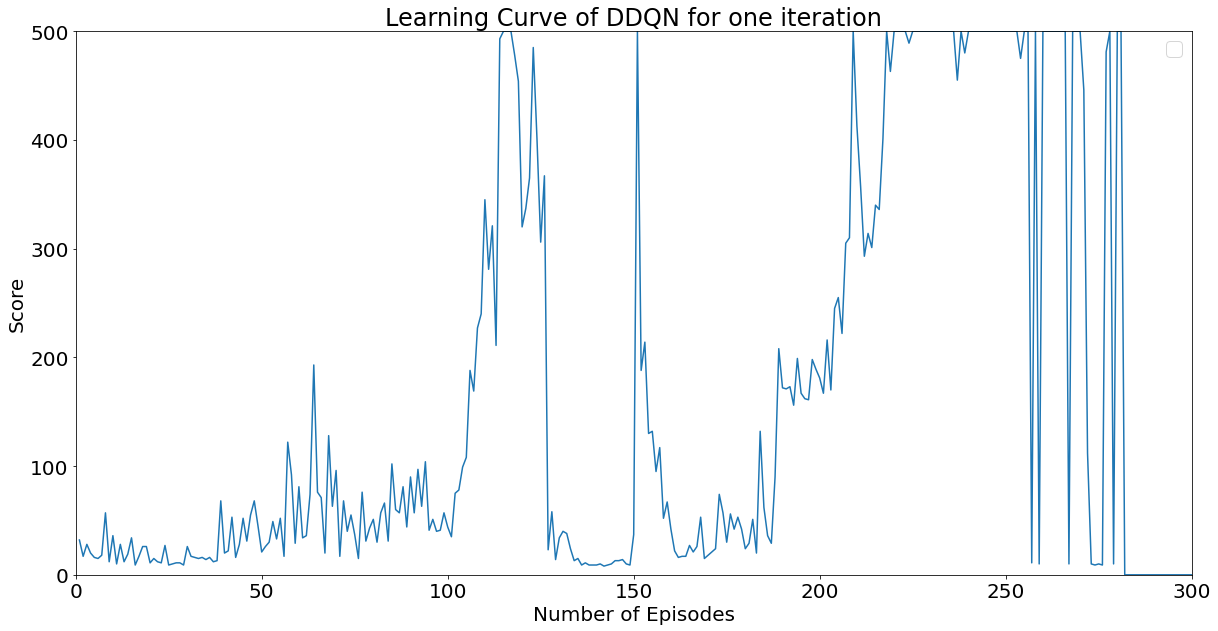

In [19]:

# plt.figure(figsize=(20,10))

# x = [i+1 for i in range(len(scores))]
# plt.plot(x,scores)
# plt.xlim([0,300])
# plt.ylim([0,500])
# plt.xlabel('Number of Episodes')
# plt.ylabel('Score')
# plt.title('Learning Curve of DDQN for one iteration')
# plt.legend()
# plt.show()

# UNCOMMENT FOR ONE ITERATION

# episodes = 300
# mean_rewards = []
# mean_squared = []
# std_rewards = []
# std = 0
# k_frames = [2, 4, 8, 16, 20]
# env = gym.make('CartPole-v1')
# env = FrameStack(env, k_frames[2])
# env.reset()
# k_input = k_frames[2] * len(env.state)
# k_output = env.action_space.n
# eps_history=[]
# steps_array=[]
# scores=np.zeros(episodes)
# total_avg_score=[]
# all_scores=[]

# agent = DQNAgent(input_dims=k_input, n_actions=k_output, mem_size=100000)

# for i in range(episodes):

#   score = 0
#   duration = []
#   avg_score=[]
#   done = False
#   obs = env.reset()
#   obs = T.tensor(obs).float().view(-1).unsqueeze(0).to(device)
#   for t in count():
#     action = agent.select_action(obs)
#     next_obs, reward, done, info = env.step(action.item())
#     reward = T.tensor([reward], device=device)
#     score += int(reward)
    
#     if not done:
#       next_obs = T.tensor(next_obs).float().view(-1).unsqueeze(0).to(device)
#     else: 
#       next_obs = None
#     # print("Learning...")
#     agent.memory.push(obs, action, reward, next_obs)
#     obs = next_obs
    
#     agent.learn(obs, action, reward, next_obs)
      # agent.learn_dqnn(obs, action, reward, next_obs)  # for DDQN implementation
#     # obs = next_obs
#     # print("Learned!")
#     if done:
#       duration.append(t+1)
#       break
  
#   agent.replace_target_network(i)
#   scores[i] += score
#   eps_history.append(agent.epsilon)
#   steps_array.append(duration)
#   agent.decay_epsilon()

#   if i%25==0:
#     print('episode: ', i, ' score ', score, ' duration ', duration, ' epsilon ', agent.epsilon) 

# print('ITERATION 1 done')
# mean_rewards.append(scores)
# mean_squared.append(scores**2)
# std_rewards.append(0)

# plot_vanilla_LC(scores,eps_history)

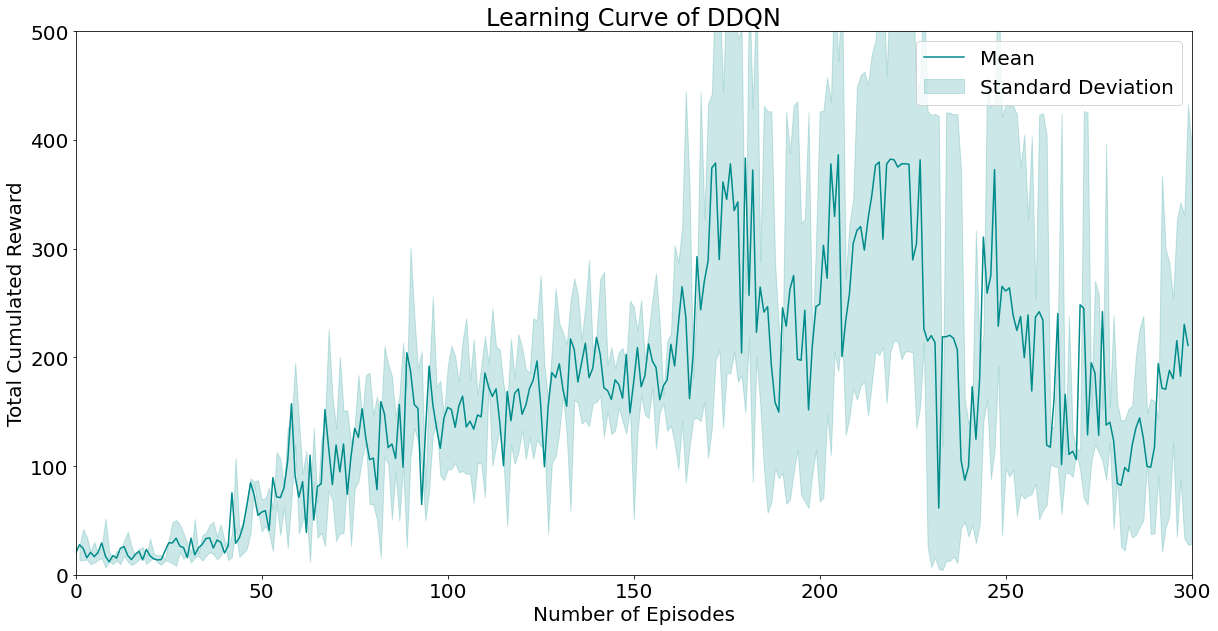

In [12]:
### DDQN

# mean_rewards_0 = mean_rewards
# std_rewards_0 = std_rewards
# plt.rcParams.update({'font.size': 20})

# plt.figure(figsize=(20,10))

# x = [i+1 for i in range(len(scores))]

# plt.plot(mean_rewards_0[:][4], label='Mean', color='darkcyan')
# plt.fill_between(x,(mean_rewards_0[:][4] - std_rewards_0[:][4]), (mean_rewards_0[:][4] + std_rewards_0[:][4]), color='darkcyan', alpha=0.2,label='Standard Deviation')

# plt.xlim([0,300])
# plt.ylim([0,500])
# plt.xlabel('Number of Episodes')
# plt.ylabel('Total Cumulated Reward')
# plt.title('Learning Curve of DDQN')
# plt.legend()
# plt.show()

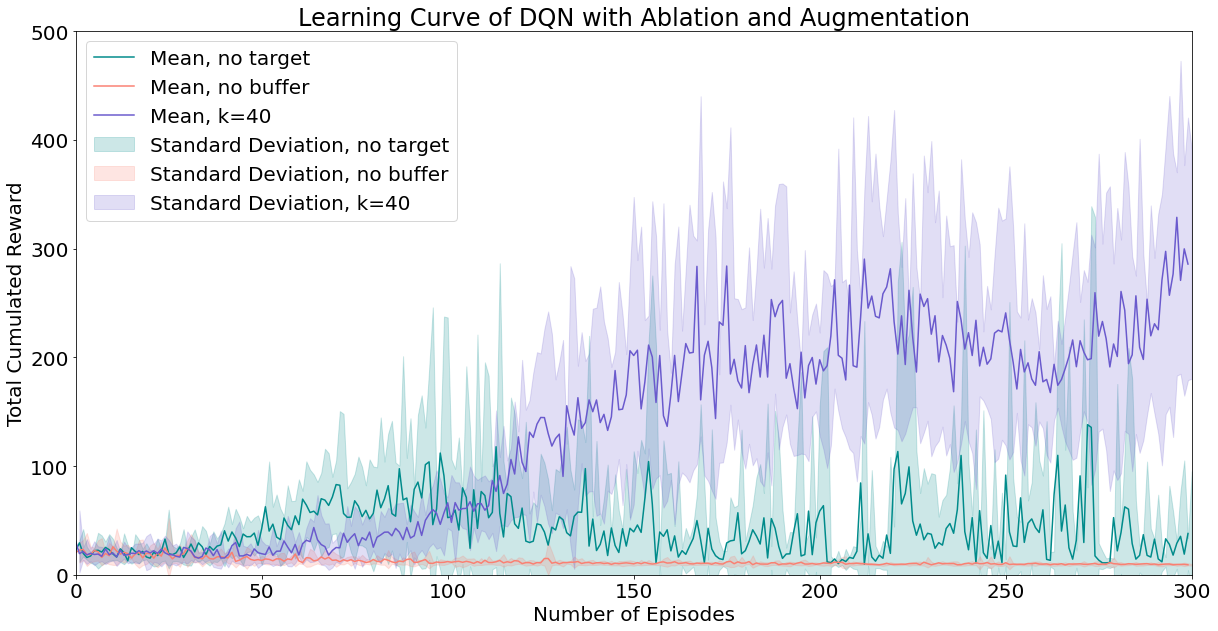

In [149]:
#### PLOTTING ABLATION AND AUGMENTATION EXPERIMENTS

# mean_rewards_2 = mean_rewards
# std_rewards_2 = std_rewards
# plt.rcParams.update({'font.size': 20})

# plt.figure(figsize=(20,10))

# x = [i+1 for i in range(len(scores))]
# plt.plot(mean_rewards_0[:][9], label='Mean, no target', color='darkcyan')
# plt.fill_between(x,(mean_rewards_0[:][9] - std_rewards_0[:][9]), (mean_rewards_0[:][9] + std_rewards_0[:][9]), color='darkcyan', alpha=0.2,label='Standard Deviation, no target')

# plt.plot(mean_rewards_1[:][9], label='Mean, no buffer', color='salmon')
# plt.fill_between(x,(mean_rewards_1[:][9] - std_rewards_1[:][9]), (mean_rewards_1[:][9] + std_rewards_1[:][9]), color='salmon', alpha=0.2,label='Standard Deviation, no buffer')

# plt.plot(mean_rewards_2[:][9], label='Mean, k=40', color='slateblue')
# plt.fill_between(x,(mean_rewards_2[:][9] - std_rewards_2[:][9]), (mean_rewards_2[:][9] + std_rewards_2[:][9]), color='slateblue', alpha=0.2,label='Standard Deviation, k=40')

# plt.xlim([0,300])
# plt.ylim([0,500])
# plt.xlabel('Number of Episodes')
# plt.ylabel('Total Cumulated Reward')
# plt.title('Learning Curve of DQN with Ablation and Augmentation')
# plt.legend()
# plt.show()


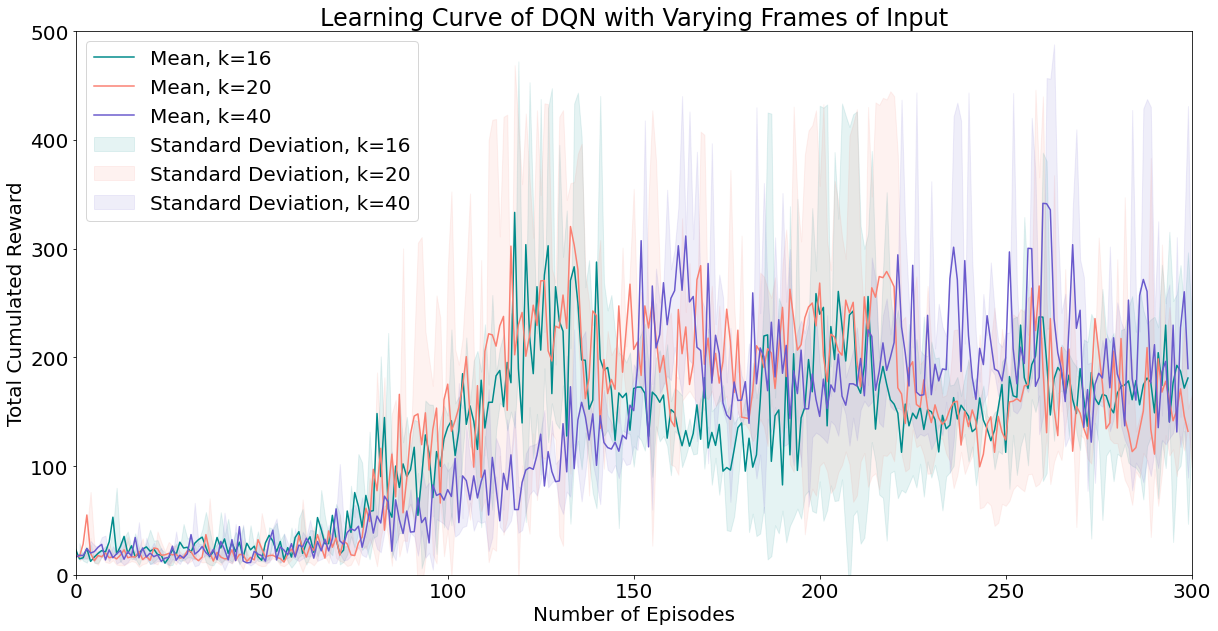

In [ ]:
#### TUNING REPLAY BUFFER SIZE 

# as my learning curve is sometimes quite stochastic - learning rises and dips,
# I've manually located a point where the std is best - around the range of 100-125 episodes
# the list below has the values for my calculated std's

# std_list = [45.507020215444655, 47.86323107447814, 68.26907547833548, 69.39828439765921, 42.86189039433102, 37.49666651850535, 39.81066300488962]
# mem_length = [1000, 5000, 10000, 20000, 50000, 100000, 200000]

# plt.figure(figsize=(20,12))
# plot_LC(mean_rewards[:][4],std_rewards[:][4])
# plt.plot(std_rewards[4])
# std_67_6 = std_rewards[4][100]
# std_list.append(std_67_6)

# print(std_list)
# print(mem_length)

# plt.figure(figsize=(10,6))
# plt.plot(mem_length, std_list)

# plt.title('Standard Deviations for Varying Replay Buffer Sizes')
# plt.ylabel('Standard Deviations')
# plt.xlabel('Replay Buffer Memory Size')
# plt.xlim([1000, 200000])
# plt.xticks([1000, 5000, 10000, 20000, 50000, 100000, 200000])
# plt.xscale("log")
# plt.show()

#### TUNING K FRAMES OF INPUT

# mean_rewards_2 = mean_rewards
# std_rewards_2 = std_rewards
# plt.rcParams.update({'font.size': 20})

# plt.figure(figsize=(20,10))

# x = [i+1 for i in range(len(scores))]
# plt.plot(mean_rewards_0[:][2], label='Mean, k=16', color='darkcyan')
# plt.fill_between(x,(mean_rewards_0[:][2] - std_rewards_0[:][2]), (mean_rewards_0[:][2] + std_rewards_0[:][2]), color='darkcyan', alpha=0.1,label='Standard Deviation, k=16')

# plt.plot(mean_rewards_1[:][2], label='Mean, k=20', color='salmon')
# plt.fill_between(x,(mean_rewards_1[:][2] - std_rewards_1[:][2]), (mean_rewards_1[:][2] + std_rewards_1[:][2]), color='salmon', alpha=0.1,label='Standard Deviation, k=20')

# plt.plot(mean_rewards_2[:][2], label='Mean, k=40', color='slateblue')
# plt.fill_between(x,(mean_rewards_2[:][2] - std_rewards_2[:][2]), (mean_rewards_2[:][2] + std_rewards_2[:][2]), color='slateblue', alpha=0.1,label='Standard Deviation, k=40')

# plt.xlim([0,300])
# plt.ylim([0,500])
# plt.xlabel('Number of Episodes')
# plt.ylabel('Total Cumulated Reward')
# plt.title('Learning Curve of DQN with Varying Frames of Input')
# plt.legend()
# plt.show()

In [ ]:
## GOOGLE COLAB CRASHES DUE TO VIDEORECORDER SO THIS IS COMMENTED OUT 

# k_frames = 6
# env = gym.make("CartPole-v1")
# file_path = 'video/video_1.mp4'
# recorder = VideoRecorder(env, file_path)

# env = FrameStack(env, k_frames)
# obs = env.reset()
# k_input = k_frames * len(env.state)
# k_output = env.action_space.n

# agent = DQNAgent(input_dims=k_input, n_actions=k_output,mem_size=100000)
# state = T.tensor(obs).view(-1).float().unsqueeze(0).to(device)
# agent.epsion = 0.9
# duration = 0
# done = False
# while not done:
#     recorder.capture_frame()

#     # Select and perform an action
#     action = agent.select_action(state)
#     observation, reward, done, _ = env.step(action.item())
#     duration += 1
#     reward = T.tensor([reward], device=device)

#     # Observe new state
#     state = T.tensor(observation).view(-1).float().unsqueeze(0).to(device)

# recorder.close()
# env.close()
# print("Episode duration: ", duration)